## Lmd Ukraine - synthetic data generation - prompting tests

### Objective

- We start with our +-500 human annotated labels
- Intermediate goal 1: gen synthetic data examples + labels <- we're here
- Intermediate goal 2 : fine-tune mistral or mistral variant such as OpenHermes, or llama2.
- End goal expand dataset to several k examples. (Fine-tuned model as a classifier or SetFit Classifier + Fine-tuned model weighted avg predictions).
- Final objective : train Bert to classify --not the fine tuned Mistral, our end goal being performance/deployment. 

**Ressources**  
[MLabonne Repo](https://github.com/mlabonne/llm-course)  
[Dataset Gen - using gpt3.5](https://medium.com/@kshitiz.sahay26/how-i-created-an-instruction-dataset-using-gpt-3-5-to-fine-tune-llama-2-for-news-classification-ed02fe41c81f)  
[Kaggle Essay Gen](https://www.kaggle.com/code/phanisrikanth/generate-synthetic-essays-with-mistral-7b-instruct)  
[Dataset Gen - Mistral-7B nice prompt examples](https://hendrik.works/blog/leveraging-underrepresented-data)  
[Fine tune OpenHermes-2.5-Mistral-7B - including prompt template gen](https://towardsdatascience.com/fine-tune-a-mistral-7b-model-with-direct-preference-optimization-708042745aac)

### Installs

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install -q -U git+https://github.com/huggingface/transformers
!pip install -q flash-attn --no-build-isolation

In [3]:
# only if load_in_8bit or equivalent :
#!pip install -i https://pypi.org/simple/ bitsandbytes
#!pip install accelerate

### Libs

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM
)

### Load dataset

In [5]:
dataset_path = "gentilrenard/lmd_ukraine_comments"

In [6]:
data = load_dataset(dataset_path)
train = data["train"]
train_df = train.to_pandas()
train_df.head(1)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/gentilrenard--lmd_ukraine_comments-4494a2a28d9c6379/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

,text,label
0,Waouh on a failli avoir un article positif (pa...,2


#### Comments length

Avg text len in # car: 390.30650154798764


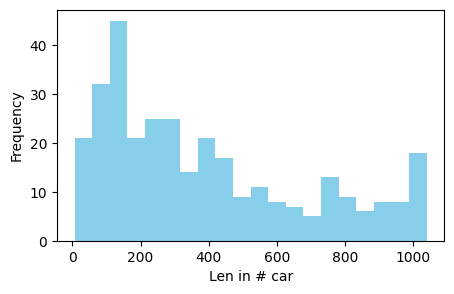

In [7]:
comm_lengths = train_df['text'].str.len()
avg_length_chars = comm_lengths.mean()

print(f'Avg text len in # car: {avg_length_chars}')

# Visualize the distribution of text lengths
plt.figure(figsize=(5, 3))
plt.hist(comm_lengths, bins=20, color='skyblue')
plt.xlabel('Len in # car')
plt.ylabel('Frequency')
plt.show()

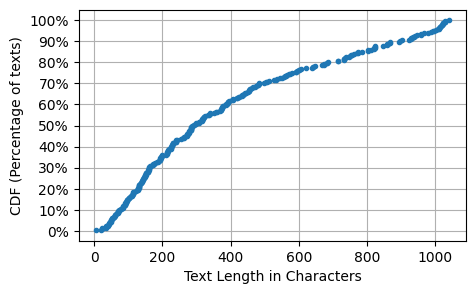

In [8]:
data_sorted = np.sort(comm_lengths)
cdf = np.arange(1, len(data_sorted)+1) / len(data_sorted)

# Plot the CDF
plt.figure(figsize=(5, 3))
plt.plot(data_sorted, cdf, marker='.', linestyle='none')
plt.xlabel('Text Length in Characters')
plt.ylabel('CDF (Percentage of texts)')
plt.grid(True)
plt.yticks(np.arange(0, 1.1, 0.1), [f'{y*100:.0f}%' for y in np.arange(0, 1.1, 0.1)])

plt.show()

### Load Mistral 7b instruct

Mistral instruct works quite ok too, OpenHermes might be better tho (quick tests)

In [9]:
# model_path="/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1"
model_path="teknium/OpenHermes-2.5-Mistral-7B"

In [10]:
tokenizer=AutoTokenizer.from_pretrained(model_path)

model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype = torch.float16, # bfloat16 throws a 'cutlass' error
    device_map = "auto",
    trust_remote_code = True,
    # load_in_8bit=True,
)

tokenizer_config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

### Prompts tests - generate one comment

Feedback post prompting: 
- Could not get best results with one single prompt -> part of prompt will be specific to each label (specify if pro ukraine, pro russia, other...) -> more consistency.
- Global, neutral context (wikipedia summary), + 3 (or more) real examples + expected format of the answer better, while still not perfect. Edit: we had good result using only one example and putting more "weight" on wanted output format. 
- Inference / text gen : conflict environment cuda <-> VLLM, could not test (as of February 2024).

In [11]:
# pro ukraine
com_1 = '"text": "il faut soutenir l ukraine et envoyer nos canons Caesar", "label": 0'
com_2 = '"text": "qu est ce qu on attend pour envoyer l OTAN? Macron ne doit pas negocier avec Poutine", "label": 0'
com_3 = '"text": "Les russes et leur dictateur en chef font crimes de guerre sur crime de guerre c est horrible", "label": 0'
com_4 = '"text": "Vous oubliez que les agresseurs sont les Russes!!", "label": 0'
com_5 = '"text": "Est ce que vous trouvez normal que les russes bombardent les civils ?", "label": 0'

In [12]:
# pro russia
com_1 = '"text": "La russie est légitime à envahir l Ukraine", "label": 1'
com_2 = '"text": "La russie va finir par gagner avec l aide economique de la Chine", "label": 1'
com_3 = '"text": "Zelinsky a voulu interdire la langue Russe donc l intervention est justifiée", "label": 1'
com_4 = '"text": "L ukraine a toujours appartenu à la Russie depuis l origine", "label": 1'
com_5 = '"text": "L ukraine ne pourra pas gagner cette guerre, Les russes sont trop puissants", "label": 1'

In [13]:
pro_ukraine = "Cet exemple est plutôt favorable à l'Ukraine / dénigre la Russie"
pro_russia = "Cet exemple est plutôt favorable à la Russie / dénigre l'Ukraine"
other_label = "Cet exemple ne parle pas directement du conflit, ou ne prend pas du tout position"

In [14]:
label_specific = pro_russia

In [15]:
# chat template
# from model card : https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1
# HF doc on how to apply with tokenizer and apply_chat_template : https://huggingface.co/docs/transformers/main/chat_templating

prompt = f'''Contexte: l'invasion de l'Ukraine par la Russie, débutée le 24 février 2022 sur ordre de Vladimir Poutine, représente une intensification majeure du conflit russo-ukrainien entamé en 2014 avec l'annexion de la Crimée et la guerre du Donbass. Malgré de fortes résistances ukrainiennes, la Russie a occupé des parties de l'Ukraine, visant à en couper l'accès à la mer. L'invasion, condamnée internationalement, a entraîné des sanctions massives contre la Russie et un soutien occidental et partiellement global à l'Ukraine. Elle a également exacerbé les crises énergétique et alimentaire mondiales. Le conflit est marqué par de graves violations des droits humains et des crimes de guerre.
Voici un exemple de commmentaire laissé par un abonné du journal lemonde.fr sous un article consacré à cette guerre. {label_specific}. Exemple: 1.{{{com_1}}}.
Génère un nouveau commentaire en français au format json, qui s'inspire de l'exemple et comporte le même label. Important, le format de réponse est un json: {{"text": "nouveau commentaire", "label": même label que l'exemple}}'''
print(prompt)

Contexte: l'invasion de l'Ukraine par la Russie, débutée le 24 février 2022 sur ordre de Vladimir Poutine, représente une intensification majeure du conflit russo-ukrainien entamé en 2014 avec l'annexion de la Crimée et la guerre du Donbass. Malgré de fortes résistances ukrainiennes, la Russie a occupé des parties de l'Ukraine, visant à en couper l'accès à la mer. L'invasion, condamnée internationalement, a entraîné des sanctions massives contre la Russie et un soutien occidental et partiellement global à l'Ukraine. Elle a également exacerbé les crises énergétique et alimentaire mondiales. Le conflit est marqué par de graves violations des droits humains et des crimes de guerre.
Voici un exemple de commmentaire laissé par un abonné du journal lemonde.fr sous un article consacré à cette guerre. Cet exemple est plutôt favorable à la Russie / dénigre l'Ukraine. Exemple: 1.{"text": "La russie est légitime à envahir l Ukraine", "label": 1}.
Génère un nouveau commentaire en français au forma

### Generate one comment

In [16]:
%%time
def generate_comm(prompt):
    messages = [{
        "role":"user",
        "content": prompt
    }]
    
    #model_inputs = tokenizer.apply_chat_template(messages, return_tensors = "pt").to('cuda')
    # with add_generation_prompt=True. Effectivness depends on the model chat template
    model_inputs = tokenizer.apply_chat_template(messages, add_generation_prompt=True, return_tensors = "pt").to('cuda')
    
    # Setting `pad_token_id` to `eos_token_id` for open-ended generation.
    # could also use transformers pipeline / GenerationConfig / max_new_tokens
    with torch.no_grad():
        generated_ids = model.generate(
            model_inputs,
            max_new_tokens = 200, # 200 tokens * 4 = max 800 chars approx.
            do_sample = True, # sampling approach, more randomness
            pad_token_id = tokenizer.eos_token_id
        )

    decoded = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    #text = decoded[0].split("[/INST]")[1] # for base mistral instruct
    text = decoded[0].split("\n assistant\n")[1] # for openHermes version, with add_generation_prompt=True
    return text

comm = generate_comm(prompt)
comm

2024-02-08 16:02:56.811032: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 16:02:56.811138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 16:02:56.967061: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


CPU times: user 21.1 s, sys: 863 ms, total: 21.9 s
Wall time: 27.2 s


'Voici un exemple de commentaire en français au format JSON, qui s\'inspire de l\'exemple donné et comporte le même label:\n\n{"text": "La Russie agit dans son intérêt national et défend ses droits territoriaux face à l\'expansionnisme d\'un pays pro-occidental comme l\'Ukraine. L\'ensemble des actions ukrainiennes, soutenus par l\'Ouest, ont poussé la Russie à agir pour préserver ses propres intérêts stratégiques et geopolitiques. Malgré les atteintes aux droits humains et aux principes internationaux, la réponse de la Russie est compréhensible en considérant les tensions historiques et les ambitions expansionnistes de l\'Ukraine et de ses alliés occidentaux.", "'